In [37]:
import pandas as pd
import numpy as np
from data_columns import childhood, demographic, diagnosis, all
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.decomposition import PCA
import umap

In [38]:
df = pd.read_csv('./data/imputed_mental_health_data.csv')

In [39]:
value_groups = defaultdict(list)

for col in diagnosis():
    if col in df.columns:
        unique_vals = frozenset(df[col].dropna().unique())
        value_groups[unique_vals].append(col)

In [40]:
print("\n🔷 Diagnosis columns with value set [1, 5]:")
one_five_cols = []
for unique_vals, cols in value_groups.items():
    if unique_vals == frozenset([1, 5]):
        one_five_cols.extend(cols)
        for col in cols:
            print(f"  - {col}")


🔷 Diagnosis columns with value set [1, 5]:


In [41]:
print("\n🔶 Diagnosis columns with value set [0, 1, 2] or similar:")
zero_one_two_cols = []
for unique_vals, cols in value_groups.items():
    if unique_vals == frozenset([0, 1, 2]) or (unique_vals.issuperset({1, 2}) and 0 in unique_vals):
        zero_one_two_cols.extend(cols)
        for col in cols:
            print(f"  - {col}")


🔶 Diagnosis columns with value set [0, 1, 2] or similar:


In [42]:
one_five_counts = {col: (df[col] == 1).sum() for col in one_five_cols}
zero_one_two_counts = {col: ((df[col] == 1) | (df[col] == 2)).sum() for col in zero_one_two_cols}

top_1_5 = sorted(one_five_counts.items(), key=lambda x: x[1], reverse=True)[:10]
top_0_1_2 = sorted(zero_one_two_counts.items(), key=lambda x: x[1], reverse=True)[:10]


In [43]:
combined_top = []

for col, count in top_1_5:
    combined_top.append((col, "1/5", count))

for col, count in top_0_1_2:
    combined_top.append((col, "0/1/2", count))

combined_top_sorted = sorted(combined_top, key=lambda x: x[2], reverse=True)


In [44]:
print("\n✅ Top 10 Diagnosis Fields (Sorted by Count):")
for col, coding, count in combined_top_sorted:
    print(f"{col:<30} | Type: {coding:<6} | Count: {count}")



✅ Top 10 Diagnosis Fields (Sorted by Count):


In [45]:
#-9,-7 remove
#-6 refuse keep, -8 dont know maybe keep?
def get_filtered_features_for_diagnosis(df, diagnosis_col, positive_values, min_presence=0.3, columns_to_remove=None):
    if isinstance(positive_values, int):
        positive_values = [positive_values]
    if columns_to_remove is None:
        columns_to_remove = []

    diagnosed_df = df[df[diagnosis_col].isin(positive_values)].copy()
    print(f"[Subset] {diagnosed_df.shape[0]} rows match {diagnosis_col} ∈ {positive_values}")

    diagnosed_df.drop(columns=[col for col in columns_to_remove if col in diagnosed_df.columns], inplace=True)

    numeric_df = diagnosed_df.select_dtypes(include=['int64', 'float64'])

    valid_cols = [
        col for col in numeric_df.columns
        if (numeric_df[col] >= 0).mean() >= min_presence
    ]

    final_df = numeric_df[valid_cols]
    print(f"[Filter] {len(valid_cols)} features retained with ≥ {min_presence*100:.0f}% non-negative values")
    return final_df, valid_cols

In [46]:
admin_cols = ['RESPID', 'NCS1YR', 'AGE', 'STR', 'CASEID', 'COMPLETE', 'SECU', 'CASEWGT']
checkpoint_cols = ['M5A', 'IR3', 'IR11_4', 'IR36', 'IR47', 'PD0A', 'PD2', 'PD5', 'PD14', 'PD20', 'PD23', 'AG2', 'AG7', 'AG10', 
                   'FD4_1', 'FD6', 'FD7_1', 'FD9_1', 'PR1', 'PR11_1', 'PR15', 'FN1', 'FN4', 'FN24', 'CN1_2', 'CN4', 'CN4_1',
                   'CN7_1', 'CN7_2', 'CN8', 'CN14', 'DA36_2B', 'DA36_3A_1', 'DE20_3', 'DE20_6', 'CH23', 'CH38_1', 'CH74_1',
                   'CH104', 'AD0', 'AD2', 'AD7', 'AD29', 'AD31', 'AD36', 'AD43_2', 'OD2', 'OD27', 'CD3', 'CD17_1', 'CD24', 'SA1E_1',
                   'SA2', 'SA3', 'SA7A1', 'SA10', 'SA11E_1', 'SA12', 'SA18_5']
cols_to_remove = admin_cols + checkpoint_cols + diagnosis()

filtered_features, retained_cols = get_filtered_features_for_diagnosis(
    df=df,
    diagnosis_col='DSM_MJD',
    positive_values=1,
    min_presence=0.4,
    columns_to_remove= cols_to_remove  
)

[Subset] 4006 rows match DSM_MJD ∈ [1]
[Filter] 555 features retained with ≥ 40% non-negative values


In [47]:
def run_umap_clustering(df, n_clusters=3, n_components=2, random_state=42):
    reducer = umap.UMAP(n_components=n_components, random_state=random_state)
    X_embedded = reducer.fit_transform(df)

    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init='auto')
    labels = kmeans.fit_predict(X_embedded)

    if n_components == 2:
        plt.figure(figsize=(8, 6))
        scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=labels, cmap='tab10', alpha=0.7)
        plt.title("UMAP Projection with Cluster Labels")
        plt.xlabel("UMAP 1")
        plt.ylabel("UMAP 2")
        plt.colorbar(scatter, label="Cluster ID")
        plt.grid(True)
        plt.show()

    return X_embedded, labels

/Users/nial/Desktop/Github_Repo/milestone-2-siads-696/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nial/Desktop/Github_Repo/milestone-2-siads-696/venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


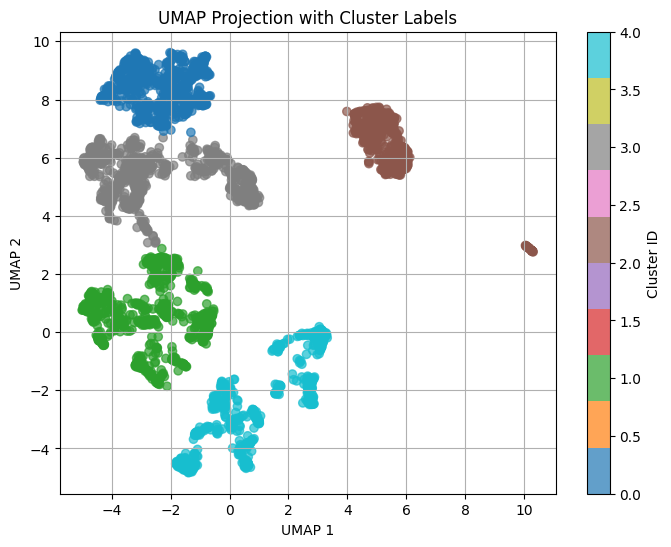

In [48]:
X_umap, cluster_labels = run_umap_clustering(filtered_features, n_clusters=5)

In [49]:
def describe_clusters(df_with_labels, cluster_col='cluster', top_n=20):
    cluster_summary = df_with_labels.groupby(cluster_col).mean()

    for cluster_id in cluster_summary.index:
        print(f"\n🔍 Top traits in cluster {cluster_id}:")
        print(cluster_summary.loc[cluster_id].sort_values(ascending=False).head(top_n))

    return cluster_summary

In [50]:
filtered_features['cluster'] = cluster_labels

cluster_summary = describe_clusters(filtered_features)


🔍 Top traits in cluster 0:
D_AGOWO12    1.000000
D_AGO12      1.000000
CD16H        0.998621
DE20_2       0.997185
LE2          0.996898
LE5          0.995520
LE3          0.992762
NSD1B        0.992762
CH37E        0.991742
CD16F        0.991728
PEC47        0.991384
LE4          0.991039
PEC73        0.990350
EMP_WORK     0.988540
CH37D        0.988401
PEC74        0.987937
LE1          0.987248
PEC66        0.987248
PEC49        0.986903
CH74         0.986638
Name: 0, dtype: float64

🔍 Top traits in cluster 1:
RESEX        1.000000
D_AGOWO12    1.000000
D_AGO12      1.000000
LE2          0.999699
LE5          0.999397
DE20_2       0.999297
CD16H        0.998870
LE3          0.998794
PEC64        0.998192
CD16F        0.997966
CD16D        0.997966
D_ADD12      0.996835
CD16C        0.995178
PEC66        0.994952
CD16G        0.994952
PEC68        0.994876
DA36_1       0.994575
CH37D        0.994401
CD16E        0.994349
PEC69        0.993671
Name: 1, dtype: float64

🔍 Top traits in